# See the diff of (h-bond or non-h-bond) b/w strong and week attention by each head

- hbond combination / Attention strong combination.
- hbond combination / all combination.

In [1]:
%config IPCompleter.use_jedi=False

In [2]:
import os
import subprocess
import pickle
from tqdm import tqdm
import pandas as pd
pd.options.display.float_format = '{:.5g}'.format

import numpy as np
from analysis_util import calc_melt_df
from matplotlib import pyplot as plt
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import sys
from scipy.stats import ttest_ind_from_stats

sys.path.append('../streamlit/')

flatten = lambda xlist: [x for xx in xlist for x in xx]
pickleload = lambda p: pickle.load(open(p,"rb"))



In [3]:
DATETIME = '20220211_191954'

DICT_PDBID_2_Atten12 = pickleload(
    f"./DICT_PDB_Result/{DATETIME}_DICT_PDBID_2_Atten12.pickle"
)
DICT_PDBID_2_MELTDIST = pickleload(
    f"./DICT_PDB_Result/{DATETIME}_DICT_PDBID_2_MELTDIST_allatoms.pickle"
)

DICT_PDBID_2_model_out = pickleload(
    f"./DICT_PDB_Result/{DATETIME}_DICT_PDBID_2_model_out.pickle"
)

POSITIVE_PRED_IDS = [
    k for k, v in DICT_PDBID_2_model_out.items()
    if DICT_PDBID_2_model_out[k][-1] > 0.5
]


STATS_COLUMNS = [
        'Large Attention of TCRs', 
        'Small Attention of TCRs', 
        'Large Attention of Peptides', 
        'Small Attention of Peptides', 
                    ]


def get_attention_and_hhb_relationship(strong_atten=False, head_count = 4, std_thh = 3):
    givenPEP_distributedTCR_by_head = {}
    givenTCR_distributedPEP_by_head = {}
    for hi in range(head_count):
        givenTCR_distributedPEP_by_head[hi] = []
        givenPEP_distributedTCR_by_head[hi] = []
        for p, (a1_by_head, a2_by_head) in DICT_PDBID_2_Atten12.items():
            if p not in POSITIVE_PRED_IDS:
                continue
            a1, a2 = calc_melt_df(
                DICT_PDBID_2_MELTDIST[p], a1_by_head[hi], a2_by_head[hi]
            )
            a1["pdbid"] = p
            a2["pdbid"] = p
            if strong_atten == True:
                temp1 = a1[
                    (
                            a1["value_y"]
                            > (a1["value_y"].mean() + std_thh * a1["value_y"].std())
                    )
                ].copy()
                temp2 = a2[
                    (
                            a2["value_y"]
                            > (a2["value_y"].mean() + std_thh * a2["value_y"].std())
                    )
                ].copy()
            else:
                temp1 = a1[
                    (
                            a1["value_y"]
                            <= (a1["value_y"].mean() + std_thh * a1["value_y"].std())
                    )
                ].copy()
                temp2 = a2[
                    (
                            a2["value_y"]
                            <= (a2["value_y"].mean() + std_thh * a2["value_y"].std())
                    )
                ].copy()
            temp1["head"] = hi
            temp2["head"] = hi
            givenPEP_distributedTCR_by_head[hi] += [temp2]
            givenTCR_distributedPEP_by_head[hi] += [temp1]
    return givenPEP_distributedTCR_by_head, givenTCR_distributedPEP_by_head


In [4]:
NEEDED_PDBIDS = ["2VLK", "5WKF", "3PQY", "4MJI", "4P2Q", "2YPL", "1J8H", "4P2R", "5MEN", "3MV8", "4OZF", "3VXR", "3VXS", "4OZG", "5TEZ", "2J8U", "6Q3S", "4JRX", "3VXU", "1U3H", "4JRY", "4Z7V", "4JFE", "4JFD", "3QIU", "2Z31", "2BNR", "3MBE", "4OZH", "2NX5", "5NHT", "4QOK", "5D2L", "1D9K", "4P2O", "5WKH", "6EQB", "2VLR", "6EQA"]
print(len(NEEDED_PDBIDS))


39


In [5]:
# New
distance_path = './residue_distances.parquet'

if os.path.exists(distance_path):
    df_distance = pd.read_parquet(distance_path)
else:
    DATETIME = '20220211_191954'
    DICT_PDBID_2_MELTDIST = pickleload(
        f"/Users/kyoheikoyama/workspace/tcrpred/analysis/DICT_PDB_Result/{DATETIME}_DICT_PDBID_2_MELTDIST_allatoms.pickle"
    )
    df_distance = pd.concat([df.assign(pdbid=k) for k,df in DICT_PDBID_2_MELTDIST.items()])
    df_distance.to_parquet(distance_path)

dist_tcr_side = pd.merge(df_distance[['pdbid','tcr', 'value']].groupby(['pdbid','tcr'], as_index=False).min(), 
         df_distance, 
         on=['pdbid','tcr', 'value'],
        ).rename(columns={'value':'distance_value', 'peptide':'peptide_min'})

dist_peptide_side = pd.merge(df_distance[['pdbid','peptide', 'value']].groupby(['pdbid','peptide'], as_index=False).min(), 
         df_distance, 
         on=['pdbid','peptide', 'value'],
        ).rename(columns={'value':'distance_value', 'tcr':'tcr_min'})


In [6]:
df_distance.pdbid.drop_duplicates().isin(NEEDED_PDBIDS).sum()

39

# By Taking Minimum

In [7]:
def print_out_ttest(min_df2_strong_atten, min_df2_normal_atten, propname='distance_value'):
    describe_series1 = min_df2_strong_atten[propname].describe([0.5])
    mean1 = describe_series1.loc['mean']
    std1 = describe_series1.loc['std']
    nobs1 = len(min_df2_strong_atten)

    describe_series2 = min_df2_normal_atten[propname].describe([0.5])
    mean2 = describe_series2.loc['mean']
    std2 = describe_series2.loc['std']
    nobs2 = len(min_df2_normal_atten)
    
    ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                         mean2=mean2, std2=std2, nobs2=nobs2)    
    print(ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                     mean2=mean2, std2=std2, nobs2=nobs2)
    )

In [8]:
stats_list = list()
# for stdthh in [1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]:
for stdthh in [ 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]:
    
    print('stdthh = ', stdthh)
    givenPEP_distributedTCR_by_head_large, givenTCR_distributedPEP_by_head_large =\
        get_attention_and_hhb_relationship(strong_atten=True, std_thh=stdthh)

    givenPEP_distributedTCR_by_head, givenTCR_distributedPEP_by_head =\
        get_attention_and_hhb_relationship(strong_atten=False, std_thh=stdthh)


    df1_strong_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head_large[hi] for hi in range(4)])) 
    df2_strong_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head_large[hi] for hi in range(4)]))
    df1_normal_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head[hi] for hi in range(4)])) 
    df2_normal_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head[hi] for hi in range(4)]))

    df1_strong_atten = df1_strong_atten.query('pdbid in @NEEDED_PDBIDS')
    df1_normal_atten = df1_normal_atten.query('pdbid in @NEEDED_PDBIDS')
    df2_strong_atten = df2_strong_atten.query('pdbid in @NEEDED_PDBIDS')
    df2_normal_atten = df2_normal_atten.query('pdbid in @NEEDED_PDBIDS')

    df1_strong_atten = pd.merge(df1_strong_atten, dist_tcr_side, on=['pdbid','tcr'], how='left')
    df1_normal_atten = pd.merge(df1_normal_atten, dist_tcr_side, on=['pdbid','tcr'], how='left' )
    df2_strong_atten = pd.merge(df2_strong_atten, dist_peptide_side, on=['pdbid','peptide'], how='left' )
    df2_normal_atten = pd.merge(df2_normal_atten, dist_peptide_side, on=['pdbid','peptide'], how='left' )

    min_df1_strong_atten = df1_strong_atten.groupby(['pdbid', 'tcr', ]).min().reset_index()
    min_df1_normal_atten = df1_normal_atten.groupby(['pdbid', 'tcr', ]).min().reset_index()
    min_df2_strong_atten = df2_strong_atten.groupby(['pdbid', 'peptide', ]).min().reset_index()
    min_df2_normal_atten = df2_normal_atten.groupby(['pdbid', 'peptide', ]).min().reset_index()

    min_df1_normal_atten = min_df1_normal_atten[
        ~min_df1_normal_atten[['pdbid','tcr']].apply(tuple,axis=1).isin(
            (min_df1_strong_atten[['pdbid','tcr']].apply(tuple,axis=1)))
    ]

    min_df2_normal_atten = min_df2_normal_atten[
        ~min_df2_normal_atten[['pdbid','peptide']].apply(tuple,axis=1).isin(
            (min_df2_strong_atten[['pdbid','peptide']].apply(tuple,axis=1)))
    ]

    stats = pd.concat([
        min_df1_strong_atten.distance_value.describe([0.5]),  min_df1_normal_atten.distance_value.describe([0.5]),
        min_df2_strong_atten.distance_value.describe([0.5]),  min_df2_normal_atten.distance_value.describe([0.5]),
    ], axis=1).rename(index={'50%':'median'})
    stats.columns = STATS_COLUMNS
    display(stats.loc[['count','mean'], :])
    stats.index = [f'{i} stdthh_{stdthh}' for i in stats.index]
    stats_list.append(stats)
    
    print('TCR', end=' ')
    print_out_ttest(min_df1_strong_atten, min_df1_normal_atten)
    print('Peptide', end=' ')
    print_out_ttest(min_df2_strong_atten, min_df2_normal_atten)    

stdthh =  2


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,569,468,372,65
mean,7.9392,8.9922,5.0319,6.1692


TCR Ttest_indResult(statistic=-3.7831756541680828, pvalue=0.00016371628595920472)
Peptide Ttest_indResult(statistic=-3.0506012585208375, pvalue=0.0024235110633054214)
stdthh =  2.5


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,441,596,325,112
mean,8.1005,8.6467,4.911,6.0426


TCR Ttest_indResult(statistic=-1.9396231836609699, pvalue=0.052696934605251856)
Peptide Ttest_indResult(statistic=-3.7437185790164498, pvalue=0.00020566832357190763)
stdthh =  3


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,364,673,264,173
mean,8.0448,8.6144,4.8509,5.7353


TCR Ttest_indResult(statistic=-1.9528603953962522, pvalue=0.05110536380286756)
Peptide Ttest_indResult(statistic=-3.2652953658413355, pvalue=0.0011799329273218212)
stdthh =  3.5


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,299,738,219,218
mean,8.1315,8.5291,4.8533,5.5504


TCR Ttest_indResult(statistic=-1.292337388477213, pvalue=0.19652878089721895)
Peptide Ttest_indResult(statistic=-2.6201528344387874, pvalue=0.009096529250338744)
stdthh =  4


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,244,793,172,265
mean,8.1546,8.4944,4.8479,5.4303


TCR Ttest_indResult(statistic=-1.033855218979009, pvalue=0.3014453560039997)
Peptide Ttest_indResult(statistic=-2.1334508958419054, pvalue=0.03344668383634446)
stdthh =  4.5


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,196,841,137,300
mean,8.4209,8.4129,4.9052,5.3362


TCR Ttest_indResult(statistic=0.022381353779624465, pvalue=0.9821480681761572)
Peptide Ttest_indResult(statistic=-1.495166855121628, pvalue=0.13559598093988784)
stdthh =  5


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,153,884,111,326
mean,8.2248,8.4473,4.8041,5.3362


TCR Ttest_indResult(statistic=-0.5657919675119434, pvalue=0.5716578462513036)
Peptide Ttest_indResult(statistic=-1.7338015670153706, pvalue=0.08366181387772595)
stdthh =  5.5


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,118,919,81,356
mean,8.423,8.4133,4.5182,5.3564


TCR Ttest_indResult(statistic=0.021976074286672993, pvalue=0.9824712767468564)
Peptide Ttest_indResult(statistic=-2.4460679731342276, pvalue=0.01483755573700187)
stdthh =  6


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,97,940,48,389
mean,8.2079,8.4357,4.3593,5.3049


TCR Ttest_indResult(statistic=-0.4757292794231806, pvalue=0.6343676496975424)
Peptide Ttest_indResult(statistic=-2.2178205144141367, pvalue=0.027082982585828006)


In [9]:
stats_list_all = pd.concat(stats_list)
stats_list_all.loc[[i for i in stats_list_all.index if 'count' in i or 'mean' in i]].sort_index()

,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count stdthh_2,569,468,372,65
count stdthh_2.5,441,596,325,112
count stdthh_3,364,673,264,173
count stdthh_3.5,299,738,219,218
count stdthh_4,244,793,172,265
count stdthh_4.5,196,841,137,300
count stdthh_5,153,884,111,326
count stdthh_5.5,118,919,81,356
count stdthh_6,97,940,48,389
mean stdthh_2,7.9392,8.9922,5.0319,6.1692


In [10]:
stdthh = 5.5 #3.5
# stdthh = 3.5 #3.5
# stdthh = 4.0 #3.5
givenPEP_distributedTCR_by_head_large, givenTCR_distributedPEP_by_head_large =\
    get_attention_and_hhb_relationship(strong_atten=True, std_thh=stdthh)

givenPEP_distributedTCR_by_head, givenTCR_distributedPEP_by_head =\
    get_attention_and_hhb_relationship(strong_atten=False, std_thh=stdthh)


df1_strong_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head_large[hi] for hi in range(4)])) 
df2_strong_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head_large[hi] for hi in range(4)]))
df1_normal_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head[hi] for hi in range(4)])) 
df2_normal_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head[hi] for hi in range(4)]))

df1_strong_atten = df1_strong_atten.query('pdbid in @NEEDED_PDBIDS')
df1_normal_atten = df1_normal_atten.query('pdbid in @NEEDED_PDBIDS')
df2_strong_atten = df2_strong_atten.query('pdbid in @NEEDED_PDBIDS')
df2_normal_atten = df2_normal_atten.query('pdbid in @NEEDED_PDBIDS')

df1_strong_atten = pd.merge(df1_strong_atten, dist_tcr_side, on=['pdbid','tcr'], how='left')
df1_normal_atten = pd.merge(df1_normal_atten, dist_tcr_side, on=['pdbid','tcr'], how='left' )
df2_strong_atten = pd.merge(df2_strong_atten, dist_peptide_side, on=['pdbid','peptide'], how='left' )
df2_normal_atten = pd.merge(df2_normal_atten, dist_peptide_side, on=['pdbid','peptide'], how='left' )

min_df1_strong_atten = df1_strong_atten.groupby(['pdbid', 'tcr', ]).min().reset_index()
min_df1_normal_atten = df1_normal_atten.groupby(['pdbid', 'tcr', ]).min().reset_index()
min_df2_strong_atten = df2_strong_atten.groupby(['pdbid', 'peptide', ]).min().reset_index()
min_df2_normal_atten = df2_normal_atten.groupby(['pdbid', 'peptide', ]).min().reset_index()

min_df1_normal_atten = min_df1_normal_atten[
    ~min_df1_normal_atten[['pdbid','tcr']].apply(tuple,axis=1).isin(
        (min_df1_strong_atten[['pdbid','tcr']].apply(tuple,axis=1)))
]
min_df2_normal_atten = min_df2_normal_atten[
    ~min_df2_normal_atten[['pdbid','peptide']].apply(tuple,axis=1).isin(
        (min_df2_strong_atten[['pdbid','peptide']].apply(tuple,axis=1)))
]

stats = pd.concat([
    min_df1_strong_atten.distance_value.describe([0.5]), 
    min_df1_normal_atten.distance_value.describe([0.5]),
    min_df2_strong_atten.distance_value.describe([0.5]), 
    min_df2_normal_atten.distance_value.describe([0.5]),], axis=1)

stats.columns = STATS_COLUMNS
print('stdthh = ', stdthh)
display(stats.rename(index={'50%':'median'}))


stdthh =  5.5


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,118,919,81,356
mean,8.423,8.4133,4.5182,5.3564
std,3.9894,4.5511,2.1588,2.9058
min,2.2843,2.3739,2.505,2.2843
median,7.864,7.4985,3.4961,4.3383
max,18.764,19.575,12.272,24.261


# By Each Head

In [11]:
# stdthh = 5.5 
stdthh = 3.50 

givenPEP_distributedTCR_by_head_large, givenTCR_distributedPEP_by_head_large = \
    get_attention_and_hhb_relationship(strong_atten=True, std_thh=stdthh)
givenPEP_distributedTCR_by_head, givenTCR_distributedPEP_by_head = \
    get_attention_and_hhb_relationship(strong_atten=False, std_thh=stdthh)

df1_strong_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head_large[hi] for hi in range(4)])) 
df2_strong_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head_large[hi] for hi in range(4)]))
df1_normal_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head[hi] for hi in range(4)])) 
df2_normal_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head[hi] for hi in range(4)]))

df1_strong_atten = df1_strong_atten.query('pdbid in @NEEDED_PDBIDS')
df1_normal_atten = df1_normal_atten.query('pdbid in @NEEDED_PDBIDS')
df2_strong_atten = df2_strong_atten.query('pdbid in @NEEDED_PDBIDS')
df2_normal_atten = df2_normal_atten.query('pdbid in @NEEDED_PDBIDS')

df1_large_atten_of_pdbHeadTP = df1_strong_atten[['pdbid','head', 'tcr']].apply(tuple, axis=1)
df2_large_atten_of_pdbHeadTP = df2_strong_atten[['pdbid','head', 'peptide']].apply(tuple, axis=1)

df1_strong_atten = df1_strong_atten.sort_values(by='value_y').drop_duplicates(subset=['pdbid','head', 'tcr'], keep='last')
df1_normal_atten = df1_normal_atten.sort_values(by='value_y').drop_duplicates(subset=['pdbid','head', 'tcr'], keep='last')
df2_strong_atten = df2_strong_atten.sort_values(by='value_y').drop_duplicates(subset=['pdbid','head', 'peptide'], keep='last')
df2_normal_atten = df2_normal_atten.sort_values(by='value_y').drop_duplicates(subset=['pdbid','head', 'peptide'], keep='last')

df1_normal_atten = df1_normal_atten[
    ~(df1_normal_atten[['pdbid','head', 'tcr']].apply(tuple, axis=1).isin(df1_large_atten_of_pdbHeadTP))
                ]

df2_normal_atten = df2_normal_atten[
    ~(df2_normal_atten[['pdbid','head', 'peptide']].apply(tuple, axis=1).isin(df2_large_atten_of_pdbHeadTP))
]


In [12]:
for ppp in df2_normal_atten.pdbid.unique():
    print(
        pd.concat([df2_strong_atten,]).query('head==0 and pdbid==@ppp').shape[0],
        pd.concat([df2_strong_atten, df2_normal_atten]).query('head==0 and pdbid==@ppp').shape[0]
    )

1 13
2 16
6 20
1 10
3 13
2 11
2 13
4 17
2 10
3 13
2 13
2 10
2 12
3 13
1 13
1 10
1 11
1 9
2 11
1 10
3 14
0 9
1 12
3 13
2 10
2 11
2 9
1 9
1 10
2 9
1 9
1 10
0 9
3 10
2 10
2 9
1 9
3 9
2 8


<AxesSubplot:>

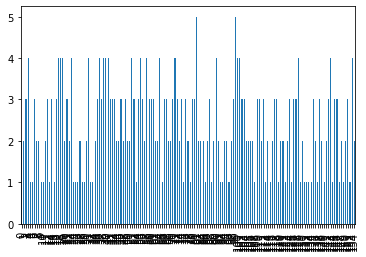

In [13]:
df1_strong_atten.groupby(by=['pdbid','head'], as_index=False).agg(len) ['tcr'].plot.bar()

<AxesSubplot:>

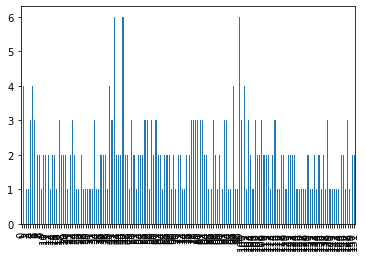

In [14]:
df2_strong_atten.groupby(by=['pdbid','head'], as_index=False).agg(len) ['peptide'].plot.bar()

# How many items are left from 80 ?

In [15]:
pd.read_csv('/Users/kyoheikoyama/Downloads/sceptre_result_v2.csv').shape

(124, 129)

In [16]:
len(DICT_PDBID_2_model_out.keys())

55

In [17]:
df_cdrs_and_peps = pd.DataFrame([tuple([DICT_PDBID_2_Atten12[p][0][0].index.tolist() + DICT_PDBID_2_Atten12[p][0][0].columns.tolist()])
                                    for p in unique_pdbid_list], columns=['pairs'], index=unique_pdbid_list)['pairs'].apply(tuple)
unique_pdbid_list = df_cdrs_and_peps.drop_duplicates().index


NameError: name 'unique_pdbid_list' is not defined

In [ ]:
givenPEP_distributedTCR_by_head, givenTCR_distributedPEP_by_head =\
    get_attention_and_hhb_relationship(strong_atten=False, std_thh=10**20)


In [ ]:
pd.concat(givenTCR_distributedPEP_by_head[0]).pdbid.unique()

# Why did you choose head0? -> No, heads are dealt equally.

In [ ]:
stdthh = 5.5 #3.5
# stdthh = 3.5 #3.5

givenPEP_distributedTCR_by_head_large, givenTCR_distributedPEP_by_head_large =\
    get_attention_and_hhb_relationship(strong_atten=True, std_thh=stdthh)

givenPEP_distributedTCR_by_head, givenTCR_distributedPEP_by_head =\
    get_attention_and_hhb_relationship(strong_atten=False, std_thh=stdthh)

df1_strong_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head_large[hi] for hi in range(4)])) 
df2_strong_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head_large[hi] for hi in range(4)]))
df1_normal_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head[hi] for hi in range(4)])) 
df2_normal_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head[hi] for hi in range(4)]))

df1_strong_atten = df1_strong_atten.query('pdbid in @NEEDED_PDBIDS')
df1_normal_atten = df1_normal_atten.query('pdbid in @NEEDED_PDBIDS')
df2_strong_atten = df2_strong_atten.query('pdbid in @NEEDED_PDBIDS')
df2_normal_atten = df2_normal_atten.query('pdbid in @NEEDED_PDBIDS')

df1_large_atten_of_pdbHeadTP = df1_strong_atten[['pdbid','head', 'tcr']].apply(tuple, axis=1)
df2_large_atten_of_pdbHeadTP = df2_strong_atten[['pdbid','head', 'peptide']].apply(tuple, axis=1)

df1_strong_atten = df1_strong_atten.sort_values(by='value_y').drop_duplicates(subset=['pdbid','head', 'tcr'], keep='last')
df1_normal_atten = df1_normal_atten.sort_values(by='value_y').drop_duplicates(subset=['pdbid','head', 'tcr'], keep='last')
df2_strong_atten = df2_strong_atten.sort_values(by='value_y').drop_duplicates(subset=['pdbid','head', 'peptide'], keep='last')
df2_normal_atten = df2_normal_atten.sort_values(by='value_y').drop_duplicates(subset=['pdbid','head', 'peptide'], keep='last')

df1_normal_atten = df1_normal_atten[
    ~(df1_normal_atten[['pdbid','head', 'tcr']].apply(tuple, axis=1).isin(df1_large_atten_of_pdbHeadTP))]
df2_normal_atten = df2_normal_atten[
    ~(df2_normal_atten[['pdbid','head', 'peptide']].apply(tuple, axis=1).isin(df2_large_atten_of_pdbHeadTP))]



In [ ]:
df1_strong_atten['head'].value_counts(), df2_strong_atten['head'].value_counts()

In [ ]:
for hi in range(4):
    v = pd.concat([df1_strong_atten, df1_normal_atten]).query('head==@hi')['value_y'].var()
    m = pd.concat([df1_strong_atten, df1_normal_atten]).query('head==@hi')['value_y'].mean()
    print(hi, v, m)

In [ ]:
# for hi in range(4):
#     m = pd.concat([df1_strong_atten, df1_normal_atten]).groupby(['pdbid', 'head'], as_index=False)\
#     .agg(np.var).query('head==@hi')['value_y'].mean()
#     print(hi, m)

In [ ]:
# pd.concat([df1_strong_atten, df1_normal_atten]).groupby(['pdbid', 'head'], as_index=False)\
#     .agg(np.var).query('head==@hi') #['value_y']

In [ ]:
len(DICT_PDBID_2_Atten12.keys())

In [ ]:
pdbid_list_55 = sorted(['2VLK', '2ICW', '5WKF', '2VLJ', '3PQY', '4MJI', '4P2Q', '2YPL', '5BRZ',
               '6RPB', '1J8H', '4P2R', '5MEN', '3MV8', '4OZF', '3VXR', '3VXS', '4OZG',
               '3MV9', '5TEZ', '2J8U', '6Q3S', '4JRX', '5WLG', '3VXU', '1U3H', '4JRY',
               '4Z7V', '2UWE', '1LP9', '3W0W', '6AVF', '2BNQ', '4JFE', '4JFD', '3QIU',
               '6AVG', '2Z31', '2BNR', '5ISZ', '5KS9', '3MV7', '3MBE', '4OZH', '2NX5',
               '5NHT', '4QOK', '5D2L', '1D9K', '1FYT', '4P2O', '5WKH', '6EQB', '2VLR',
               '6EQA'])

POSITIVE_PRED_IDS = [
    k for k, v in DICT_PDBID_2_model_out.items()
    if DICT_PDBID_2_model_out[k][-1] > 0.5
]

cdrs_and_peps = pd.DataFrame([tuple([DICT_PDBID_2_Atten12[p][0][0].index.tolist() + DICT_PDBID_2_Atten12[p][0][0].columns.tolist()])
                                        for p in pdbid_list_55], columns=['pairs'], index=pdbid_list_55)['pairs'].apply(tuple)

cdrs_and_peps

In [ ]:
print([k in pdbid_list_55 for k in POSITIVE_PRED_IDS])

In [ ]:
a = cdrs_and_peps.loc[POSITIVE_PRED_IDS]
b = cdrs_and_peps[~cdrs_and_peps.index.isin(POSITIVE_PRED_IDS)]

In [ ]:
a.drop_duplicates().shape, b.drop_duplicates().shape

In [ ]:
cdrs_and_peps.drop_duplicates().shape

In [ ]:
cdrs_and_peps.loc[POSITIVE_PRED_IDS].drop_duplicates().shape

In [ ]:
POSITIVE_PRED_IDS

In [ ]:
cdrs_and_peps.sort_index()

In [ ]:
len(sorted(cdrs_and_peps.drop_duplicates().index.tolist()))

In [ ]:
print(sorted(cdrs_and_peps.drop_duplicates().index.tolist()))

In [ ]:
print(sorted(POSITIVE_PRED_IDS))

In [ ]:
NEEDED_PDBIDS